### Imports iniciais

In [19]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer # Adicionado

# Carregar dados dos Alunos
df_path = "/Users/daniels/Documents/CEIA/PACTO/sim_dataset/alunos_based/data/full_dataset.csv"
df_alunos = pd.read_csv(df_path)

# Drop duplicates baseado em '_chave' e 'cliente_codigo'
df_alunos = df_alunos.drop_duplicates(subset=['_chave', 'cliente_codigo'])
df_alunos

,cliente_codigo,_chave,media_treinos_semanais,tendencia_num_treinos,duracao_media_treinos,pessoa_codigo,foi_indicado,sexo,ano_nascimento,num_convites_enviados,num_convites_recebidos,name,Philanthropist,Socialiser,Achiever,Player,Free Spirit,Disruptor,pred_dominant_hexad,pred_secondary_hexad
0,7459.0,28359f7fc700f9b9904a3b619c84022c,2.076923,-0.029541,88.421974,112303,False,1,1983,0.0,0.0,João Almeida,6.0,6.0,7.0,7.0,6.0,5.0,Achiever,Player
2,7326.0,ef9f2365f60ac8e2356e254c8c91488f,2.421053,0.058255,62.634316,8100,False,-1,1993,0.0,0.0,Clara Silva,7.0,7.0,6.0,5.0,6.0,3.0,Philanthropist,Socialiser
4,5062.0,ca13bee745eaeffb2c494385eeec9a47,2.120000,-0.074332,60.365232,21528,False,1,1989,0.0,0.0,Carlos Menezes,7.0,6.0,6.5,6.0,6.0,2.5,Philanthropist,Achiever
6,6180.0,ef9f2365f60ac8e2356e254c8c91488f,1.000000,0.000000,74.769767,6900,False,1,1987,0.0,0.0,Lucas,7.0,6.0,6.0,4.0,7.0,6.5,Philanthropist,Free Spirit
8,5458.0,ef9f2365f60ac8e2356e254c8c91488f,2.000000,-0.009946,53.048552,6115,False,-1,1994,0.0,0.0,Laura,6.0,5.0,7.0,6.0,7.0,4.0,Achiever,Free Spirit
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,5543.0,ef9f2365f60ac8e2356e254c8c91488f,2.095238,0.005602,44.813269,6213,False,1,1997,0.0,0.0,Carlos,6.0,5.0,7.0,6.0,7.0,4.0,Achiever,Free Spirit
146,14657.0,1d40882bc4bd32e41d71d18381755f93,2.360000,0.013077,67.948483,119546,False,1,1995,0.0,0.0,Lucas Almeida,6.0,4.0,7.0,5.5,7.0,4.0,Achiever,Free Spirit
147,10856.0,33fa79e54690bc45beb83343f7e3c730,1.500000,-0.285714,57.864115,11222,False,1,2007,0.0,0.0,Rodrigo,6.0,4.0,7.0,7.0,6.0,2.5,Achiever,Player
148,11254.0,a855c5c74458a07ac7301a1a8df5b7ed,3.000000,1.500000,107.035579,11808,False,-1,1978,0.0,0.0,Laura Valente,6.0,3.0,7.0,6.0,7.0,5.5,Achiever,Free Spirit


In [20]:
# Renomeia as colunas para lowercase e troca espacos por underline
df_alunos.columns = df_alunos.columns.str.lower().str.replace(' ', '_')

## Pré processamento

### User - Alunos

In [21]:
# Identificador único para alunos
df_alunos['user_id'] = df_alunos['_chave'].astype(str) + df_alunos['cliente_codigo'].astype(float).astype(int).astype(str)
df_alunos = df_alunos.drop(columns=['_chave', 'cliente_codigo'])

# One-hot encode do sexo
df_alunos = pd.get_dummies(df_alunos, columns=["sexo"], prefix="sexo")

# Converte a coluna 'foi_indicado' para float (0.0/1.0)
df_alunos['foi_indicado'] = df_alunos['foi_indicado'].astype(float)

# Colunas HEXAD (usadas para perfil do aluno e features do item)
hexad_cols = ['philanthropist', 'socialiser', 'achiever', 'player', 'free_spirit', 'disruptor']

# Adiciona um identificador da tabela de alunos para as colunas HEXAD
df_alunos.rename(columns={col: f'aluno_{col}' for col in hexad_cols}, inplace=True)

hexad_alunos_cols = [f'aluno_{col}' for col in hexad_cols]  # Atualiza os nomes das colunas HEXAD

# Colunas de features do aluno para a UserTower
# Inclui features demográficas, comportamentais e os próprios scores HEXAD do aluno
user_numeric_cols_for_scaling = [
    'media_treinos_semanais', 'tendencia_num_treinos', 'duracao_media_treinos',
    'ano_nascimento', 'num_convites_enviados', 'num_convites_recebidos'
]
# Adiciona colunas 'sexo' que foram criadas pelo get_dummies
sexo_cols = [col for col in df_alunos.columns if col.startswith('sexo_')]
user_categorical_cols = ['foi_indicado'] + sexo_cols

# Features finais do usuário (colunas de input para a UserTower)
final_user_feature_cols = []
# Adiciona colunas numéricas que precisam de scaling (e existem no DataFrame)
final_user_feature_cols.extend([col for col in user_numeric_cols_for_scaling if col in df_alunos.columns])
# Adiciona colunas categóricas já em formato 0/1 (e existem no DataFrame)
final_user_feature_cols.extend([col for col in user_categorical_cols if col in df_alunos.columns])
# Adiciona scores HEXAD do aluno como features (e existem no DataFrame)
final_user_feature_cols.extend([col for col in hexad_alunos_cols if col in df_alunos.columns])


# Remover coluna 'index' se existir (artefato do pandas read_csv)
if 'index' in df_alunos.columns:
    df_alunos = df_alunos.drop(columns=['index'])

# Divisão dos dados dos alunos para criar conjuntos de treino/validação de interações
df_alunos_train_users, df_val_users = train_test_split(df_alunos, test_size=0.3, random_state=42)

# Scaling das features numéricas dos alunos (NÃO HEXAD)
scaler = StandardScaler()
cols_to_scale_in_user_features = [col for col in user_numeric_cols_for_scaling if col in df_alunos_train_users.columns]

if cols_to_scale_in_user_features:
    # Converta as colunas para float ANTES de escalar
    for col in cols_to_scale_in_user_features:
        df_alunos_train_users[col] = df_alunos_train_users[col].astype(float)
        df_val_users[col] = df_val_users[col].astype(float)

    # Agora, fite o scaler e transforme
    scaler.fit(df_alunos_train_users[cols_to_scale_in_user_features])
    df_alunos_train_users.loc[:, cols_to_scale_in_user_features] = scaler.transform(df_alunos_train_users[cols_to_scale_in_user_features])
    df_val_users.loc[:, cols_to_scale_in_user_features] = scaler.transform(df_val_users[cols_to_scale_in_user_features])

### Items - Desafios

In [22]:
df_interactions_path = "/Users/daniels/Documents/CEIA/PACTO/sim_dataset/ratings_data/sim_20250603_234652_hexad_interactions.csv"
df_interactions = pd.read_csv(df_interactions_path)

df_interactions

,user_id,hexad_type,challenge_id,challenge_type,challenge_desc,date,event,success,streak,progress_pct,rating
0,28359f7fc700f9b9904a3b619c84022c7459,Achiever,7,Player,Complete 3 workouts with 100% execution and 5 ...,2025-05-14,workout_completed,True,1,12.5,1.0
1,28359f7fc700f9b9904a3b619c84022c7459,Achiever,7,Player,Complete 3 workouts with 100% execution and 5 ...,2025-05-15,skip,False,0,12.5,1.0
2,28359f7fc700f9b9904a3b619c84022c7459,Achiever,7,Player,Complete 3 workouts with 100% execution and 5 ...,2025-05-16,skip,False,0,12.5,1.0
3,28359f7fc700f9b9904a3b619c84022c7459,Achiever,7,Player,Complete 3 workouts with 100% execution and 5 ...,2025-05-17,skip,False,0,12.5,1.0
4,28359f7fc700f9b9904a3b619c84022c7459,Achiever,7,Player,Complete 3 workouts with 100% execution and 5 ...,2025-05-18,workout_completed,True,1,25.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2247,33fa79e54690bc45beb83343f7e3c730153,Free Spirit,1,Player,Complete 10 workouts in 14 days and unlock a b...,2025-05-13,skip,False,0,10.0,3.0
2248,33fa79e54690bc45beb83343f7e3c730153,Free Spirit,1,Player,Complete 10 workouts in 14 days and unlock a b...,2025-05-14,created_routine,False,0,10.0,3.0
2249,33fa79e54690bc45beb83343f7e3c730153,Free Spirit,1,Player,Complete 10 workouts in 14 days and unlock a b...,2025-05-15,skip,False,0,10.0,3.0
2250,33fa79e54690bc45beb83343f7e3c730153,Free Spirit,1,Player,Complete 10 workouts in 14 days and unlock a b...,2025-05-16,created_routine,True,1,20.0,3.0


In [23]:
df_interactions = df_interactions.rename(columns={'challenge_type': 'hexad_desafio', 'challenge_id': 'item_id', 'hexad_type': 'hexad_aluno'})

df_interactions = df_interactions.drop(columns=['hexad_aluno'])

# 'hexad_desafio' to one-hot encode
df_interactions = pd.get_dummies(df_interactions, columns=['hexad_desafio'], prefix='desafio')
df_interactions.columns = df_interactions.columns.str.lower().str.replace(' ', '_')

hexad_desafio_cols = [col for col in df_interactions.columns if col.startswith('desafio_')]
df_interactions

,user_id,item_id,challenge_desc,date,event,success,streak,progress_pct,rating,desafio_achiever,desafio_disruptor,desafio_free_spirit,desafio_philanthropist,desafio_player,desafio_socialiser
0,28359f7fc700f9b9904a3b619c84022c7459,7,Complete 3 workouts with 100% execution and 5 ...,2025-05-14,workout_completed,True,1,12.5,1.0,False,False,False,False,True,False
1,28359f7fc700f9b9904a3b619c84022c7459,7,Complete 3 workouts with 100% execution and 5 ...,2025-05-15,skip,False,0,12.5,1.0,False,False,False,False,True,False
2,28359f7fc700f9b9904a3b619c84022c7459,7,Complete 3 workouts with 100% execution and 5 ...,2025-05-16,skip,False,0,12.5,1.0,False,False,False,False,True,False
3,28359f7fc700f9b9904a3b619c84022c7459,7,Complete 3 workouts with 100% execution and 5 ...,2025-05-17,skip,False,0,12.5,1.0,False,False,False,False,True,False
4,28359f7fc700f9b9904a3b619c84022c7459,7,Complete 3 workouts with 100% execution and 5 ...,2025-05-18,workout_completed,True,1,25.0,1.0,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2247,33fa79e54690bc45beb83343f7e3c730153,1,Complete 10 workouts in 14 days and unlock a b...,2025-05-13,skip,False,0,10.0,3.0,False,False,False,False,True,False
2248,33fa79e54690bc45beb83343f7e3c730153,1,Complete 10 workouts in 14 days and unlock a b...,2025-05-14,created_routine,False,0,10.0,3.0,False,False,False,False,True,False
2249,33fa79e54690bc45beb83343f7e3c730153,1,Complete 10 workouts in 14 days and unlock a b...,2025-05-15,skip,False,0,10.0,3.0,False,False,False,False,True,False
2250,33fa79e54690bc45beb83343f7e3c730153,1,Complete 10 workouts in 14 days and unlock a b...,2025-05-16,created_routine,True,1,20.0,3.0,False,False,False,False,True,False


In [24]:
# Carregar modelo de embedding
embedding_model = SentenceTransformer('all-MiniLM-L6-v2') # Você pode escolher outros modelos

# Gerar embeddings para 'challenge_desc'
# Certifique-se de que não há NaNs ou converta-os para string vazia
df_interactions['challenge_desc'] = df_interactions['challenge_desc'].fillna('') 
challenge_desc_embeddings = embedding_model.encode(df_interactions['challenge_desc'].tolist())

# Adicionar embeddings ao DataFrame
# Cada dimensão do embedding se tornará uma nova coluna
embedding_dim_size = challenge_desc_embeddings.shape[1]
embedding_cols = [f'desc_emb_{i}' for i in range(embedding_dim_size)]
df_interactions = pd.concat(
    [df_interactions, pd.DataFrame(challenge_desc_embeddings, index=df_interactions.index, columns=embedding_cols)],
    axis=1
).copy()

# Atualizar item_feature_cols para incluir 'hexad_desafio' e as novas colunas de embedding
# Mantendo 'hexad_desafio' se ainda for relevante, ou ajuste conforme necessário.
# Se 'challenge_desc' original não for mais necessária como feature direta, remova-a.
item_feature_cols = hexad_desafio_cols + embedding_cols

# Remover a coluna original 'challenge_desc' se os embeddings a substituem completamente como feature
# df_interactions = df_interactions.drop(columns=['challenge_desc'])


In [25]:
def create_engagement_score(success, rating, weight_success=0.6, weight_rating=0.4):
    """
    Cria um score de engajamento mais sofisticado
    """
    normalized_rating = rating / 10.0
    # Penaliza ratings muito baixos mesmo com sucesso
    penalty = np.where(rating < 3, 0.5, 1.0)
    
    score = (success.astype(float) * weight_success + 
             normalized_rating * weight_rating) * penalty
    
    return np.clip(score, 0, 1)

df_interactions['label'] = create_engagement_score(
    df_interactions['success'], 
    df_interactions['rating']
)

In [26]:
train_interactions_df = pd.merge(df_alunos_train_users, df_interactions, on='user_id', how='left')

val_interactions_df = pd.merge(df_val_users, df_interactions, on='user_id', how='left')

In [27]:
train_interactions_df

,media_treinos_semanais,tendencia_num_treinos,duracao_media_treinos,pessoa_codigo,foi_indicado,ano_nascimento,num_convites_enviados,num_convites_recebidos,name,aluno_philanthropist,...,desc_emb_375,desc_emb_376,desc_emb_377,desc_emb_378,desc_emb_379,desc_emb_380,desc_emb_381,desc_emb_382,desc_emb_383,label
0,-0.968557,-1.714963,-1.074390,114332,0.0,0.675352,-0.120386,0.0,Mariana Silva,7.0,...,0.083299,-0.063292,-0.033127,-0.039794,0.015473,0.042480,-0.032939,-0.025614,0.027842,0.8
1,-0.968557,-1.714963,-1.074390,114332,0.0,0.675352,-0.120386,0.0,Mariana Silva,7.0,...,0.055445,-0.064992,0.042554,-0.118477,0.040182,0.038789,-0.119890,-0.075426,0.045722,0.0
2,-0.968557,-1.714963,-1.074390,114332,0.0,0.675352,-0.120386,0.0,Mariana Silva,7.0,...,0.055445,-0.064992,0.042554,-0.118477,0.040182,0.038789,-0.119890,-0.075426,0.045722,0.0
3,-0.968557,-1.714963,-1.074390,114332,0.0,0.675352,-0.120386,0.0,Mariana Silva,7.0,...,0.055445,-0.064992,0.042554,-0.118477,0.040182,0.038789,-0.119890,-0.075426,0.045722,0.0
4,-0.968557,-1.714963,-1.074390,114332,0.0,0.675352,-0.120386,0.0,Mariana Silva,7.0,...,0.055445,-0.064992,0.042554,-0.118477,0.040182,0.038789,-0.119890,-0.075426,0.045722,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,1.750073,0.367372,-0.325306,121754,0.0,-1.098751,-0.120386,0.0,Carlos Oliveira,6.0,...,0.101609,-0.034257,-0.081043,-0.107047,0.062744,0.054565,-0.042685,0.031389,-0.017763,0.0
1616,1.750073,0.367372,-0.325306,121754,0.0,-1.098751,-0.120386,0.0,Carlos Oliveira,6.0,...,0.101609,-0.034257,-0.081043,-0.107047,0.062744,0.054565,-0.042685,0.031389,-0.017763,0.0
1617,1.750073,0.367372,-0.325306,121754,0.0,-1.098751,-0.120386,0.0,Carlos Oliveira,6.0,...,0.101609,-0.034257,-0.081043,-0.107047,0.062744,0.054565,-0.042685,0.031389,-0.017763,0.0
1618,1.750073,0.367372,-0.325306,121754,0.0,-1.098751,-0.120386,0.0,Carlos Oliveira,6.0,...,0.101609,-0.034257,-0.081043,-0.107047,0.062744,0.054565,-0.042685,0.031389,-0.017763,0.0


In [28]:
def add_feedback_data(df):
    """
    Adiciona dados de feedback ao DataFrame de interações.
    """
    
    # Normalizar streak e progress_pct
    df['streak_normalized'] = df['streak'] / (df['streak'].max() + 1e-8)
    df['progress_normalized'] = df['progress_pct'] / 100.0

    # Features de contexto do usuário (baseadas no histórico)
    df = df.sort_values(['user_id', 'date'])

    # Streak médio histórico do usuário
    df['user_avg_streak'] = df.groupby('user_id')['streak'].transform(
        lambda x: x.expanding().mean().shift(1)
    ).fillna(0)

    # Progresso médio histórico do usuário
    df['user_avg_progress'] = df.groupby('user_id')['progress_pct'].transform(
        lambda x: x.expanding().mean().shift(1)
    ).fillna(50.0)

    # Taxa de sucesso histórica do usuário
    df['user_success_rate'] = df.groupby('user_id')['success'].transform(
        lambda x: x.expanding().mean().shift(1)
    ).fillna(0.5)

    return df

train_interactions_df = add_feedback_data(train_interactions_df)
val_interactions_df = add_feedback_data(val_interactions_df)

In [29]:
# Adicionar às features do usuário (histórico)
user_history_features = ['user_avg_streak', 'user_avg_progress', 'user_success_rate']
final_user_feature_cols.extend(user_history_features)

In [30]:
train_interactions_df[final_user_feature_cols]

,media_treinos_semanais,tendencia_num_treinos,duracao_media_treinos,ano_nascimento,num_convites_enviados,num_convites_recebidos,foi_indicado,sexo_-1,sexo_0,sexo_1,aluno_philanthropist,aluno_socialiser,aluno_achiever,aluno_player,aluno_free_spirit,aluno_disruptor,user_avg_streak,user_avg_progress,user_success_rate
1358,-0.525302,0.174920,-0.797547,-0.472597,-0.120386,0.0,0.0,False,False,True,6.0,6.0,7.0,7.0,6.0,2.5,0.000000,50.000000,0.500000
1359,-0.525302,0.174920,-0.797547,-0.472597,-0.120386,0.0,0.0,False,False,True,6.0,6.0,7.0,7.0,6.0,2.5,0.000000,0.000000,0.000000
1360,-0.525302,0.174920,-0.797547,-0.472597,-0.120386,0.0,0.0,False,False,True,6.0,6.0,7.0,7.0,6.0,2.5,0.000000,0.000000,0.000000
1361,-0.525302,0.174920,-0.797547,-0.472597,-0.120386,0.0,0.0,False,False,True,6.0,6.0,7.0,7.0,6.0,2.5,0.333333,3.333333,0.333333
1362,-0.525302,0.174920,-0.797547,-0.472597,-0.120386,0.0,0.0,False,False,True,6.0,6.0,7.0,7.0,6.0,2.5,0.750000,7.500000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,-0.377550,2.303579,-0.381188,0.153557,-0.120386,0.0,0.0,True,False,False,6.0,7.0,5.5,5.5,7.0,6.0,0.312500,21.250000,0.312500
710,-0.377550,2.303579,-0.381188,0.153557,-0.120386,0.0,0.0,True,False,False,6.0,7.0,5.5,5.5,7.0,6.0,0.294118,21.764706,0.294118
711,-0.377550,2.303579,-0.381188,0.153557,-0.120386,0.0,0.0,True,False,False,6.0,7.0,5.5,5.5,7.0,6.0,0.277778,22.222222,0.277778
712,-0.377550,2.303579,-0.381188,0.153557,-0.120386,0.0,0.0,True,False,False,6.0,7.0,5.5,5.5,7.0,6.0,0.315789,23.157895,0.315789


In [31]:
train_interactions_df[item_feature_cols]

,desafio_achiever,desafio_disruptor,desafio_free_spirit,desafio_philanthropist,desafio_player,desafio_socialiser,desc_emb_0,desc_emb_1,desc_emb_2,desc_emb_3,...,desc_emb_374,desc_emb_375,desc_emb_376,desc_emb_377,desc_emb_378,desc_emb_379,desc_emb_380,desc_emb_381,desc_emb_382,desc_emb_383
1358,True,False,False,False,False,False,0.080315,-0.004271,0.052828,-0.003845,...,0.050194,0.088670,-0.046901,-0.097141,-0.006513,0.010817,0.106266,-0.056690,-0.046650,0.030542
1359,True,False,False,False,False,False,0.080315,-0.004271,0.052828,-0.003845,...,0.050194,0.088670,-0.046901,-0.097141,-0.006513,0.010817,0.106266,-0.056690,-0.046650,0.030542
1360,True,False,False,False,False,False,0.080315,-0.004271,0.052828,-0.003845,...,0.050194,0.088670,-0.046901,-0.097141,-0.006513,0.010817,0.106266,-0.056690,-0.046650,0.030542
1361,True,False,False,False,False,False,0.080315,-0.004271,0.052828,-0.003845,...,0.050194,0.088670,-0.046901,-0.097141,-0.006513,0.010817,0.106266,-0.056690,-0.046650,0.030542
1362,True,False,False,False,False,False,0.080316,-0.004271,0.052828,-0.003845,...,0.050194,0.088670,-0.046901,-0.097141,-0.006513,0.010817,0.106266,-0.056690,-0.046650,0.030542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,False,False,False,False,True,False,-0.025416,0.067764,0.009172,-0.021908,...,0.009555,0.112931,-0.009443,-0.084028,-0.104609,0.104912,0.055429,0.013588,0.007407,-0.039588
710,False,False,False,False,True,False,-0.025416,0.067764,0.009172,-0.021908,...,0.009555,0.112931,-0.009443,-0.084028,-0.104609,0.104912,0.055429,0.013588,0.007407,-0.039588
711,False,False,False,False,True,False,-0.025416,0.067764,0.009172,-0.021908,...,0.009555,0.112931,-0.009443,-0.084028,-0.104609,0.104912,0.055429,0.013588,0.007407,-0.039588
712,False,False,False,False,True,False,-0.025416,0.067764,0.009172,-0.021908,...,0.009555,0.112931,-0.009443,-0.084028,-0.104609,0.104912,0.055429,0.013588,0.007407,-0.039588


## Dataset

In [32]:
class InteractionDataset(Dataset):
    def __init__(self, dataframe, user_feature_cols, item_input_feature_cols, target_label_cols): # Modificado
        self.dataframe = dataframe.reset_index(drop=True)
        self.user_feature_cols = user_feature_cols
        self.item_input_feature_cols = item_input_feature_cols # Modificado
        self.target_label_cols = target_label_cols # Modificado

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        
        user_features_np = row[self.user_feature_cols].values.astype(np.float32)
        item_features_np = row[self.item_input_feature_cols].values.astype(np.float32) # Modificado para usar item_input_feature_cols
        targets_np = row[self.target_label_cols].values.astype(np.float32) # Modificado para usar target_label_cols
        
        if np.isnan(user_features_np).any():
            print(f"Warning: NaN encontrado nas features do usuário no índice {idx}. Substituindo por 0.")
            user_features_np = np.nan_to_num(user_features_np)
        if np.isnan(item_features_np).any():
            print(f"Warning: NaN encontrado nas features do item no índice {idx}. Substituindo por 0.")
            item_features_np = np.nan_to_num(item_features_np)
        if np.isnan(targets_np).any(): # Adicionado check para NaNs nos targets
            print(f"Warning: NaN encontrado nos targets no índice {idx}. Substituindo por 0.")
            targets_np = np.nan_to_num(targets_np)

        user_features = torch.tensor(user_features_np, dtype=torch.float32)
        item_features = torch.tensor(item_features_np, dtype=torch.float32)
        targets = torch.tensor(targets_np, dtype=torch.float32) # Modificado para targets
        
        return user_features, item_features, targets # Modificado

# Colunas de input para a UserTower (definidas durante o pré-processamento)
user_tower_input_cols = final_user_feature_cols
# Colunas de input para o Item (apenas embeddings)
item_tower_input_cols = embedding_cols # Usar apenas as colunas de embedding como input do item
# Colunas de target (tipos de desafio one-hot encoded)
target_cols = hexad_desafio_cols

train_dataset = InteractionDataset(train_interactions_df, user_tower_input_cols, item_tower_input_cols, target_cols) # Modificado
val_dataset = InteractionDataset(val_interactions_df, user_tower_input_cols, item_tower_input_cols, target_cols) # Modificado

In [33]:
labels = ["desafio_achiever", "desafio_disruptor", "desafio_free_spirit", "desafio_philanthropist", "desafio_player", "desafio_socialiser"]
input_features = [col for col in user_tower_input_cols if col not in labels] + [col for col in item_feature_cols if col not in labels]

## Model

In [34]:
class RecSys(nn.Module):
    def __init__(
            self,
            input_dim: int,
            output_dim: int,
            hidden_dims: list[int] = [128, 64],
            dropout: float = 0.2
    ):
        super(RecSys, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        h1, h2 = hidden_dims

        # Camada de entrada
        self.fc1 = nn.Linear(input_dim, h1)
        self.bn1 = nn.BatchNorm1d(h1)
        self.drop1 = nn.Dropout(dropout)

        # Camada oculta
        self.fc2 = nn.Linear(h1, h2)
        self.bn2 = nn.BatchNorm1d(h2)
        self.drop2 = nn.Dropout(dropout)

        # Camada de saída
        self.output = nn.Linear(h2, output_dim)


    def forward(self, x):
        # Passa pela primeira camada
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.drop1(x)

        # Passa pela segunda camada
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.drop2(x)

        # Passa pela camada de saída
        logits = self.output(x)
        # probs = torch.sigmoid(logits) # Removido sigmoid, pois BCEWithLogitsLoss já aplica
        return logits # Modificado para retornar logits

In [35]:
# Definindo o modelo
model = RecSys(
    input_dim=len(input_features),
    output_dim=len(labels),
    hidden_dims=[128, 64],
    dropout=0.2
)

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Definindo o otimizador e a função de perda
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

# Definindo o DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [36]:
# Treinamento
num_epochs = 20

epoch_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    # Modificado para desempacotar user_features, item_features, e targets
    for user_features_batch, item_features_batch, targets_batch in tqdm(train_loader):
        # Concatena user e item features para criar o input do modelo
        x_batch = torch.cat((user_features_batch, item_features_batch), dim=1).to(device)
        y_batch = targets_batch.to(device) # y_batch são os targets
        
        optimizer.zero_grad()
        
        y_hat_batch = model(x_batch)
        
        loss = criterion(y_hat_batch, y_batch)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x_batch.size(0) # Multiplica pela batch size para obter a perda total da batch
    epoch_loss = running_loss / len(train_loader.dataset) # Divide pelo número total de amostras
    epoch_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        # Modificado para desempacotar user_features, item_features, e targets
        for user_features_batch, item_features_batch, targets_batch in val_loader:
            x_batch = torch.cat((user_features_batch, item_features_batch), dim=1).to(device)
            y_batch = targets_batch.to(device)
            y_hat_batch = model(x_batch)
            loss = criterion(y_hat_batch, y_batch)
            val_loss += loss.item() * x_batch.size(0) # Multiplica pela batch size

    val_loss /= len(val_loader.dataset) # Divide pelo número total de amostras
    print(f"Validation Loss: {val_loss:.4f}")    

100%|██████████| 51/51 [00:03<00:00, 14.97it/s]



Epoch 1/20, Loss: 0.4957
Validation Loss: 0.3523
Validation Loss: 0.3523


100%|██████████| 51/51 [00:00<00:00, 66.22it/s]



Epoch 2/20, Loss: 0.2101
Validation Loss: 0.1766
Validation Loss: 0.1766


100%|██████████| 51/51 [00:00<00:00, 68.01it/s]



Epoch 3/20, Loss: 0.1085
Validation Loss: 0.0828
Validation Loss: 0.0828


100%|██████████| 51/51 [00:00<00:00, 67.54it/s]



Epoch 4/20, Loss: 0.0665
Validation Loss: 0.0522
Validation Loss: 0.0522


100%|██████████| 51/51 [00:00<00:00, 67.20it/s]



Epoch 5/20, Loss: 0.0448
Validation Loss: 0.0348
Validation Loss: 0.0348


100%|██████████| 51/51 [00:00<00:00, 68.27it/s]



Epoch 6/20, Loss: 0.0311
Validation Loss: 0.0212
Validation Loss: 0.0212


100%|██████████| 51/51 [00:00<00:00, 66.03it/s]



Epoch 7/20, Loss: 0.0228
Validation Loss: 0.0168
Validation Loss: 0.0168


100%|██████████| 51/51 [00:00<00:00, 64.73it/s]



Epoch 8/20, Loss: 0.0187
Validation Loss: 0.0125
Validation Loss: 0.0125


100%|██████████| 51/51 [00:00<00:00, 66.05it/s]



Epoch 9/20, Loss: 0.0152
Validation Loss: 0.0085
Validation Loss: 0.0085


100%|██████████| 51/51 [00:00<00:00, 66.31it/s]



Epoch 10/20, Loss: 0.0124
Validation Loss: 0.0066
Validation Loss: 0.0066


100%|██████████| 51/51 [00:00<00:00, 66.59it/s]



Epoch 11/20, Loss: 0.0099
Validation Loss: 0.0051
Validation Loss: 0.0051


100%|██████████| 51/51 [00:00<00:00, 66.90it/s]



Epoch 12/20, Loss: 0.0086
Validation Loss: 0.0050
Validation Loss: 0.0050


100%|██████████| 51/51 [00:00<00:00, 65.48it/s]



Epoch 13/20, Loss: 0.0103
Validation Loss: 0.0053
Validation Loss: 0.0053


100%|██████████| 51/51 [00:00<00:00, 66.55it/s]



Epoch 14/20, Loss: 0.0086
Validation Loss: 0.0036
Validation Loss: 0.0036


100%|██████████| 51/51 [00:00<00:00, 66.40it/s]



Epoch 15/20, Loss: 0.0060
Validation Loss: 0.0027
Validation Loss: 0.0027


100%|██████████| 51/51 [00:00<00:00, 65.92it/s]



Epoch 16/20, Loss: 0.0052
Validation Loss: 0.0021
Validation Loss: 0.0021


100%|██████████| 51/51 [00:00<00:00, 66.66it/s]



Epoch 17/20, Loss: 0.0039
Validation Loss: 0.0021
Validation Loss: 0.0021


100%|██████████| 51/51 [00:00<00:00, 66.69it/s]



Epoch 18/20, Loss: 0.0038
Validation Loss: 0.0015
Validation Loss: 0.0015


100%|██████████| 51/51 [00:00<00:00, 66.29it/s]



Epoch 19/20, Loss: 0.0037
Validation Loss: 0.0012
Validation Loss: 0.0012


100%|██████████| 51/51 [00:00<00:00, 66.31it/s]



Epoch 20/20, Loss: 0.0034
Validation Loss: 0.0016
Validation Loss: 0.0016


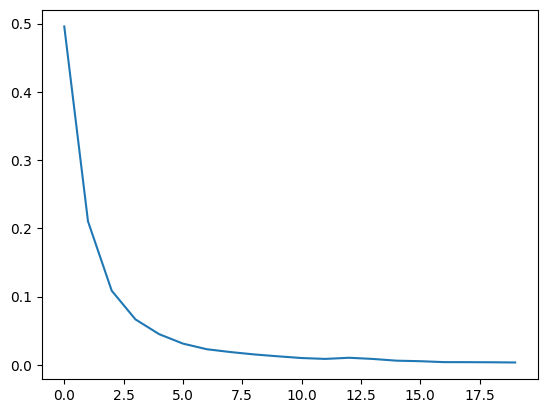

In [37]:
# Plotando a perda
plt.plot(epoch_losses)